In [1]:
import dask.dataframe as dd
import dask.distributed
import numpy as np

In [2]:
client = dask.distributed.Client()

In [4]:
# Print column names

df0 = dd.read_parquet('/data/all_trips.parquet', engine='fastparquet', index='pickup_datetime')
df0.columns

Index(['dropoff_datetime', 'dropoff_latitude', 'dropoff_longitude',
       'dropoff_taxizone_id', 'ehail_fee', 'extra', 'fare_amount',
       'improvement_surcharge', 'mta_tax', 'passenger_count', 'payment_type',
       'pickup_latitude', 'pickup_longitude', 'pickup_taxizone_id',
       'rate_code_id', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_distance', 'trip_type', 'vendor_id', 'trip_id'],
      dtype='object')

In [21]:
# Load only the columns we need, large speedup.

df = dd.read_parquet('/data/all_trips_spark.parquet', engine='arrow', 
                     columns=[
#                         'pickup_datetime', 
        'pickup_longitude', 'pickup_latitude', #'pickup_taxizone_id',
#                         'dropoff_datetime', 
        'dropoff_longitude', 'dropoff_latitude', #'dropoff_taxizone_id',
#                         'trip_type', 
#         'passenger_count'
        'total_amount'
                    ])


In [22]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.965919        40.771244         -73.949608         40.777058   
1        -73.997482        40.725952         -74.005936         40.735703   
2        -73.964798        40.767391         -73.977753         40.773746   
3        -74.011597        40.708832         -74.013466         40.709358   
4        -74.000648        40.718578         -73.944580         40.712368   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [23]:
df.tail()

pickup_longitude  pickup_latitude  dropoff_longitude  \
1432504               NaN              NaN                NaN   
1432505               NaN              NaN                NaN   
1432506               NaN              NaN                NaN   
1432507               NaN              NaN                NaN   
1432508               NaN              NaN                NaN   

         dropoff_latitude  total_amount  
1432504               NaN      8.300000  
1432505               NaN     17.299999  
1432506               NaN     41.759998  
1432507               NaN      6.300000  
1432508               NaN     14.300000

In [24]:
#Select only those points within some reasonable bounds (half a degree)

df = df[df.pickup_latitude.notnull() & df.pickup_longitude.notnull() 
        & ((df.pickup_latitude - 40.75).abs() <= 0.5) 
        & ((df.pickup_longitude + 73.9).abs() <= 0.5)
       ]
df = df[df.dropoff_latitude.notnull() & df.dropoff_longitude.notnull() 
        & ((df.dropoff_latitude - 40.75).abs() <= 0.5) 
        & ((df.dropoff_longitude + 73.9).abs() <= 0.5)
       ]

In [25]:
# We get about 1.27 billion points
df.count().compute()

pickup_longitude     1268170371
pickup_latitude      1268170371
dropoff_longitude    1268170371
dropoff_latitude     1268170371
total_amount         1268170371
dtype: int64

In [26]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.965919        40.771244         -73.949608         40.777058   
1        -73.997482        40.725952         -74.005936         40.735703   
2        -73.964798        40.767391         -73.977753         40.773746   
3        -74.011597        40.708832         -74.013466         40.709358   
4        -74.000648        40.718578         -73.944580         40.712368   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [27]:
def convert_lon(d, latvar):
    "Convert longitude to web mercator"
    k = d[latvar].copy()
    k = (20037508.34 / 180) * (np.log(np.tan((90. + d[latvar]) * np.pi/360))/(np.pi/180.))
    return k

In [28]:
# Convert lats and lons to web mercator projection
df['pickup_longitude'] = df.pickup_longitude * (20037508.34 / 180)
df['pickup_latitude'] = df.map_partitions(convert_lon, 'pickup_latitude')
df['dropoff_longitude'] = df.dropoff_longitude * (20037508.34 / 180)
df['dropoff_latitude'] = df.map_partitions(convert_lon, 'dropoff_latitude')

In [29]:
# Consolidate partitions for faster plotting
df.repartition(npartitions=200).to_parquet('/tmp/filtered.parquet', compression='SNAPPY')

In [30]:
# Read the consolidated data back in
df = dd.read_parquet('/tmp/filtered.parquet')

In [31]:
# Subsample the data 
# It's currently commented out, but it's useful 
# when iterating on plot details (axes, ranges, etc.), 
# as it greatly speeds up plot redrawing. 

# df = client.persist(df.sample(frac=0.02))

In [32]:
df.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -8233848.5        4978660.0         -8232033.0         4979513.0   
1        -8237362.0        4972004.0         -8238303.0         4973436.5   
2        -8233724.0        4978093.5         -8235166.0         4979025.5   
3        -8238933.5        4969490.0         -8239141.5         4969566.0   
4        -8237714.5        4970922.5         -8231473.0         4970009.0   

   total_amount  
0      5.800000  
1      5.400000  
2      5.800000  
3      4.600000  
4     27.799999

In [61]:
import datashader as ds
import datashader.transfer_functions as tf

import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

In [62]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show

output_notebook()

#set centers, bounds, and ranges in web mercator coords
x_center = -8234000 
y_center = 4973000

x_half_range = 30000
y_half_range = 25000

NYC = x_range, y_range = ((x_center - x_half_range, x_center + x_half_range), 
                          (y_center-y_half_range, y_center+y_half_range))

# plot_width scales (quadratically?) with memory consumption.
# With 32GB RAM, I can set this to 2000, but 2500 crashes with MemoryError.
# I used this setting for high quality, large plots. 
# plot_width = 2000 

# plot_width of 400 seems to require less than 4GB, and makes the notebook more manageable. 
# Also changes aesthetic appearance by decreasing GPS "noise" due to coarse binning
plot_width  = 400 

# auto calculate from width
plot_height = int(plot_width/(x_half_range/y_half_range))

def base_plot(tools='pan,wheel_zoom,reset,save',plot_width=plot_width, 
              plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    p.add_tools(BoxZoomTool(match_aspect=True))
    
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

## Pickups

In [40]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_1(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('total_amount'))
    img = tf.shade(agg, cmap=viridis, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

In [41]:
p = base_plot(background_fill_color=background)
export(create_image_1(x_range, y_range, plot_width, plot_height),"pickups_large_wide")
InteractiveImage(p, create_image_1)

## Dropoffs

In [42]:
background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_2(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('total_amount'))
    img = tf.shade(agg, cmap=inferno, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

In [43]:
p = base_plot(background_fill_color=background)
export(create_image_2(x_range, y_range, plot_width, plot_height),"dropoffs_large_wide")
InteractiveImage(p, create_image_2)

## Pickups (Green) vs Dropoffs (Orange)

In [44]:
background = 'black'
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))


def create_image_3(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    drops = cvs.points(df, 'dropoff_longitude', 'dropoff_latitude', ds.count('total_amount'))
    picks = cvs.points(df, 'pickup_longitude', 'pickup_latitude', ds.count('total_amount'))
    more_drops = tf.shade(drops.where(drops > picks), cmap=inferno, how='eq_hist')
    more_picks = tf.shade(picks.where(picks > drops), cmap=viridis,  how='eq_hist')
    img = tf.stack(more_picks,more_drops)
    return tf.dynspread(img, threshold=0.5, max_px=4)

In [45]:
p = base_plot(background_fill_color=background)
export(create_image_3(x_range, y_range, plot_width, plot_height),"pickups_dropoffs_large_wide")
InteractiveImage(p, create_image_3)

/home/shekhar/anaconda3/lib/python3.5/site-packages/toolz/functoolz.py:621: RuntimeWarning: invalid value encountered in over
  return func(b, a)


# Section 2, zoomed plots

In [46]:
x_center = -8234000 
y_center = 4975000

x_half_range = int(15000 / 1.5)
y_half_range = int(12500 / 1.5)

NYC = x_range, y_range = ((x_center - x_half_range, x_center + x_half_range), 
                          (y_center-y_half_range, y_center+y_half_range))

# plot_width scales (quadratically?) with memory consumption.
# With 32GB RAM, I can set this to 2000, but 2500 crashes with MemoryError.
# I used this setting for high quality, large plots. 
# plot_width = 2000 

# plot_width of 400 seems to require less than 4GB, and makes the notebook more manageable. 
# Also changes aesthetic appearance by decreasing GPS "noise" due to coarse binning
plot_width  = 400 


å
# auto calculate from width
plot_height = int(plot_width/(x_half_range/y_half_range))

background = 'black'
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

In [47]:
p = base_plot(background_fill_color=background)
export(create_image_1(x_range, y_range, plot_width, plot_height),"pickups_large_close")
InteractiveImage(p, create_image_1)

In [48]:
p = base_plot(background_fill_color=background)
export(create_image_2(x_range, y_range, plot_width, plot_height),"dropoffs_large_close")
InteractiveImage(p, create_image_2)

In [49]:
p = base_plot(background_fill_color=background)
export(create_image_3(x_range, y_range, plot_width, plot_height),"pickups_dropoffs_large_close")
InteractiveImage(p, create_image_3)

/home/shekhar/anaconda3/lib/python3.5/site-packages/toolz/functoolz.py:621: RuntimeWarning: invalid value encountered in over
  return func(b, a)


# GPS Accuracy

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import matplotlib
from matplotlib import rcParams

rcParams['savefig.dpi'] = 300

In [42]:
rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 12
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'

import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

In [3]:
import pandas as pd

In [4]:
df = dd.read_parquet('/data/all_trips.parquet', index='pickup_datetime', columns=[
        'pickup_latitude', 'pickup_longitude', 'pickup_taxizone_id',
        'dropoff_latitude', 'dropoff_longitude', 'dropoff_taxizone_id',
    ], engine='fastparquet')

In [5]:
df.head()

pickup_latitude  pickup_longitude  pickup_taxizone_id  \
pickup_datetime                                                              
2009-01-01 00:00:00        40.771244        -73.965919               237.0   
2009-01-01 00:00:00        40.725952        -73.997482               114.0   
2009-01-01 00:00:02        40.767391        -73.964798               237.0   
2009-01-01 00:00:04        40.708832        -74.011597               261.0   
2009-01-01 00:00:07        40.718578        -74.000648               144.0   

                     dropoff_latitude  dropoff_longitude  dropoff_taxizone_id  
pickup_datetime                                                                
2009-01-01 00:00:00         40.777058         -73.949608                263.0  
2009-01-01 00:00:00         40.735703         -74.005936                249.0  
2009-01-01 00:00:02         40.773746         -73.977753                 43.0  
2009-01-01 00:00:04         40.709358         -74.013466                261.0  
2009-01-01 00:00:07         40.712368         -73.944580                 80.0

In [6]:
df['pickup_datetime_str'] = df.index.astype(str)

In [7]:
df = df[df.pickup_datetime_str < '2016-07-01']

In [8]:
df['pickup_datetime_str'] = df.pickup_datetime_str.str.slice(0, 7)

In [9]:
df = df[df.pickup_latitude.notnull() & df.pickup_longitude.notnull() 
        & ((df.pickup_latitude - 40.75).abs() <= 0.5) 
        & ((df.pickup_longitude + 73.9).abs() <= 0.5)
       ]
df = df[df.dropoff_latitude.notnull() & df.dropoff_longitude.notnull() 
        & ((df.dropoff_latitude - 40.75).abs() <= 0.5) 
        & ((df.dropoff_longitude + 73.9).abs() <= 0.5)
       ]

In [10]:
z = df.groupby('pickup_datetime_str').count().compute()

In [14]:
z['pickup_valid_fraction'] = z['pickup_taxizone_id'].astype(np.float64) / z['pickup_longitude'].astype(np.float64)
z['dropoff_valid_fraction'] = z['dropoff_taxizone_id'].astype(np.float64) / z['dropoff_longitude'].astype(np.float64)

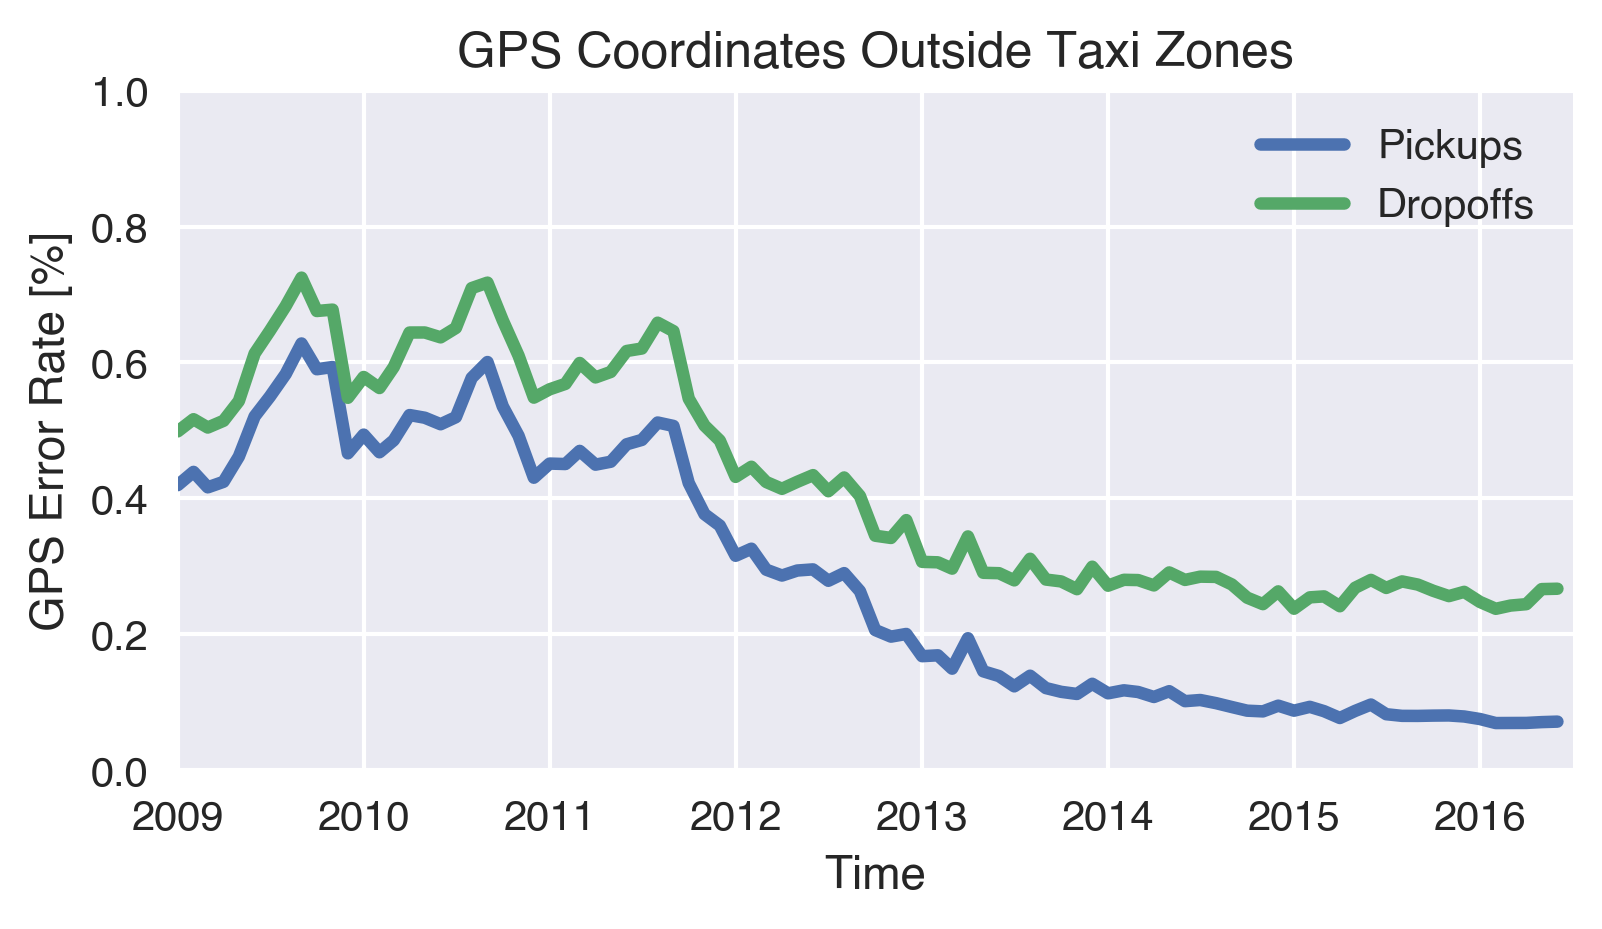

In [46]:
plt.plot(z.index.astype('M8[M]').values, 100*(1.0 - z.pickup_valid_fraction.values), 
          label='Pickups', lw=3)
plt.plot(z.index.astype('M8[M]').values, 100*(1.0 - z.dropoff_valid_fraction.values), 
          label='Dropoffs', lw=3)
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("GPS Error Rate [%]")
plt.title("GPS Coordinates Outside Taxi Zones")
plt.ylim(0, 1)
plt.xlim('2009-01', '2016-07')
plt.gcf().set_size_inches(6, 3)